In [21]:
!pip install pandas==1.5.3

import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

print(pd.__version__)

1.5.3


In [22]:
data = pd.read_csv('modis_ndvi_series.csv')
data = data.filter(regex=r'loc|20')
data.head()

,2002_01_01,2002_01_17,2002_02_02,2002_02_18,2002_03_06,2002_03_22,2002_04_07,2002_04_23,2002_05_09,2002_05_25,...,2021_08_13,2021_08_29,2021_09_14,2021_09_30,2021_10_16,2021_11_01,2021_11_17,2021_12_03,2021_12_19,loc
0,0.14,0.15,0.15,0.16,0.16,0.16,0.16,0.15,0.14,0.13,...,0.13,0.13,0.13,0.13,0.13,0.13,0.13,0.14,0.14,L1
1,0.14,0.15,0.15,0.16,0.16,0.16,0.16,0.15,0.14,0.13,...,0.13,0.13,0.13,0.13,0.13,0.13,0.13,0.14,0.14,L2


In [23]:
melt = data.melt(id_vars='loc', var_name='day', value_name='NDVI')
melt=melt[(melt['NDVI']>0)]   # remove negative values

# get locations

melt['location'] = melt['loc'].str.extract('(\d+)', expand=False).astype(int)
melt['year'] = melt['day'].str.extract('(\d+)', expand=False).astype(int)
print(melt)

melt = melt.sort_values(['location', 'year'])

# Computing annual means 

year_mean=melt.groupby(['year', 'loc']).mean()
year_mean
# print(year_mean)
year_mean=year_mean.reset_index()
year_mean


    loc         day  NDVI  location  year
0    L1  2002_01_01  0.14         1  2002
1    L2  2002_01_01  0.14         2  2002
2    L1  2002_01_17  0.15         1  2002
3    L2  2002_01_17  0.15         2  2002
4    L1  2002_02_02  0.15         1  2002
..   ..         ...   ...       ...   ...
915  L2  2021_11_17  0.13         2  2021
916  L1  2021_12_03  0.14         1  2021
917  L2  2021_12_03  0.14         2  2021
918  L1  2021_12_19  0.14         1  2021
919  L2  2021_12_19  0.14         2  2021

[920 rows x 5 columns]


C:\Users\smufl\AppData\Local\Temp\ipykernel_1864\3079801363.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  year_mean=melt.groupby(['year', 'loc']).mean()


,year,loc,NDVI,location
0,2002,L1,0.135652,1.0
1,2002,L2,0.135652,2.0
2,2003,L1,0.137391,1.0
3,2003,L2,0.137391,2.0
4,2004,L1,0.149130,1.0
5,2004,L2,0.149130,2.0
6,2005,L1,0.133043,1.0
7,2005,L2,0.133043,2.0
8,2006,L1,0.139565,1.0
9,2006,L2,0.139565,2.0


In [24]:
year_mean.index

RangeIndex(start=0, stop=40, step=1)

In [25]:
split_point = 28
melt_train = year_mean[year_mean.index < split_point].copy()
melt_valid = year_mean[year_mean.index >= split_point].copy()

In [26]:
melt_train


,year,loc,NDVI,location
0,2002,L1,0.135652,1.0
1,2002,L2,0.135652,2.0
2,2003,L1,0.137391,1.0
3,2003,L2,0.137391,2.0
4,2004,L1,0.149130,1.0
5,2004,L2,0.149130,2.0
6,2005,L1,0.133043,1.0
7,2005,L2,0.133043,2.0
8,2006,L1,0.139565,1.0
9,2006,L2,0.139565,2.0


In [27]:
melt_valid


,year,loc,NDVI,location
28,2016,L1,0.150870,1.0
29,2016,L2,0.150870,2.0
30,2017,L1,0.134783,1.0
31,2017,L2,0.134783,2.0
32,2018,L1,0.148261,1.0
33,2018,L2,0.148261,2.0
34,2019,L1,0.200870,1.0
35,2019,L2,0.200870,2.0
36,2020,L1,0.171739,1.0
37,2020,L2,0.171739,2.0


In [28]:
melt_train['lead1'] = melt_train.groupby("loc")['NDVI'].shift(-1)
melt_train['lead2'] = melt_train.groupby("loc")['NDVI'].shift(-2)
melt_train['lead3'] = melt_train.groupby("loc")['NDVI'].shift(-3)
melt_train['lead4'] = melt_train.groupby("loc")['NDVI'].shift(-4)
melt_train['lead5'] = melt_train.groupby("loc")['NDVI'].shift(-5)

melt_train['lag1'] = melt_train.groupby("loc")['NDVI'].shift(1)
melt_train['lag2'] = melt_train.groupby("loc")['NDVI'].shift(2)
melt_train['lag3'] = melt_train.groupby("loc")['NDVI'].shift(3)

melt_train["diff_1"] = melt_train.groupby("loc")['NDVI'].diff(1)

melt_train

,year,loc,NDVI,location,lead1,lead2,lead3,lead4,lead5,lag1,lag2,lag3,diff_1
0,2002,L1,0.135652,1.0,0.137391,0.149130,0.133043,0.139565,0.136522,NaN,NaN,NaN,NaN
1,2002,L2,0.135652,2.0,0.137391,0.149130,0.133043,0.139565,0.136522,NaN,NaN,NaN,NaN
2,2003,L1,0.137391,1.0,0.149130,0.133043,0.139565,0.136522,0.123478,0.135652,NaN,NaN,0.001739
3,2003,L2,0.137391,2.0,0.149130,0.133043,0.139565,0.136522,0.123478,0.135652,NaN,NaN,0.001739
4,2004,L1,0.149130,1.0,0.133043,0.139565,0.136522,0.123478,0.127391,0.137391,0.135652,NaN,0.011739
5,2004,L2,0.149130,2.0,0.133043,0.139565,0.136522,0.123478,0.127391,0.137391,0.135652,NaN,0.011739
6,2005,L1,0.133043,1.0,0.139565,0.136522,0.123478,0.127391,0.134348,0.149130,0.137391,0.135652,-0.016087
7,2005,L2,0.133043,2.0,0.139565,0.136522,0.123478,0.127391,0.134348,0.149130,0.137391,0.135652,-0.016087
8,2006,L1,0.139565,1.0,0.136522,0.123478,0.127391,0.134348,0.129565,0.133043,0.149130,0.137391,0.006522
9,2006,L2,0.139565,2.0,0.136522,0.123478,0.127391,0.134348,0.129565,0.133043,0.149130,0.137391,0.006522


In [29]:
melt_valid['lead1'] = melt_valid.groupby("loc")['NDVI'].shift(-1)
melt_valid['lead2'] = melt_valid.groupby("loc")['NDVI'].shift(-2)
melt_valid['lead3'] = melt_valid.groupby("loc")['NDVI'].shift(-3)
melt_valid['lead4'] = melt_valid.groupby("loc")['NDVI'].shift(-4)
melt_valid['lead5'] = melt_valid.groupby("loc")['NDVI'].shift(-5)

melt_valid['lag1'] = melt_valid.groupby("loc")['NDVI'].shift(1)
melt_valid['lag2'] = melt_valid.groupby("loc")['NDVI'].shift(2)
melt_valid['lag3'] = melt_valid.groupby("loc")['NDVI'].shift(3)

melt_valid["diff_1"] = melt_valid.groupby("loc")['NDVI'].diff(1)

melt_valid

,year,loc,NDVI,location,lead1,lead2,lead3,lead4,lead5,lag1,lag2,lag3,diff_1
28,2016,L1,0.150870,1.0,0.134783,0.148261,0.200870,0.171739,0.15,NaN,NaN,NaN,NaN
29,2016,L2,0.150870,2.0,0.134783,0.148261,0.200870,0.171739,0.15,NaN,NaN,NaN,NaN
30,2017,L1,0.134783,1.0,0.148261,0.200870,0.171739,0.150000,NaN,0.150870,NaN,NaN,-0.016087
31,2017,L2,0.134783,2.0,0.148261,0.200870,0.171739,0.150000,NaN,0.150870,NaN,NaN,-0.016087
32,2018,L1,0.148261,1.0,0.200870,0.171739,0.150000,NaN,NaN,0.134783,0.150870,NaN,0.013478
33,2018,L2,0.148261,2.0,0.200870,0.171739,0.150000,NaN,NaN,0.134783,0.150870,NaN,0.013478
34,2019,L1,0.200870,1.0,0.171739,0.150000,NaN,NaN,NaN,0.148261,0.134783,0.150870,0.052609
35,2019,L2,0.200870,2.0,0.171739,0.150000,NaN,NaN,NaN,0.148261,0.134783,0.150870,0.052609
36,2020,L1,0.171739,1.0,0.150000,NaN,NaN,NaN,NaN,0.200870,0.148261,0.134783,-0.029130
37,2020,L2,0.171739,2.0,0.150000,NaN,NaN,NaN,NaN,0.200870,0.148261,0.134783,-0.029130


In [30]:
# drop rows without target values

melt_train = melt_train.dropna(subset=['lead1','lead2','lead3','lead4','lead5'])
melt_train

,year,loc,NDVI,location,lead1,lead2,lead3,lead4,lead5,lag1,lag2,lag3,diff_1
0,2002,L1,0.135652,1.0,0.137391,0.149130,0.133043,0.139565,0.136522,NaN,NaN,NaN,NaN
1,2002,L2,0.135652,2.0,0.137391,0.149130,0.133043,0.139565,0.136522,NaN,NaN,NaN,NaN
2,2003,L1,0.137391,1.0,0.149130,0.133043,0.139565,0.136522,0.123478,0.135652,NaN,NaN,0.001739
3,2003,L2,0.137391,2.0,0.149130,0.133043,0.139565,0.136522,0.123478,0.135652,NaN,NaN,0.001739
4,2004,L1,0.149130,1.0,0.133043,0.139565,0.136522,0.123478,0.127391,0.137391,0.135652,NaN,0.011739
5,2004,L2,0.149130,2.0,0.133043,0.139565,0.136522,0.123478,0.127391,0.137391,0.135652,NaN,0.011739
6,2005,L1,0.133043,1.0,0.139565,0.136522,0.123478,0.127391,0.134348,0.149130,0.137391,0.135652,-0.016087
7,2005,L2,0.133043,2.0,0.139565,0.136522,0.123478,0.127391,0.134348,0.149130,0.137391,0.135652,-0.016087
8,2006,L1,0.139565,1.0,0.136522,0.123478,0.127391,0.134348,0.129565,0.133043,0.149130,0.137391,0.006522
9,2006,L2,0.139565,2.0,0.136522,0.123478,0.127391,0.134348,0.129565,0.133043,0.149130,0.137391,0.006522


In [31]:
features = ['NDVI', 'lag1', 'lag2', 'lag3','diff_1']


In [37]:
import time

start_time = time.time()

imputer = SimpleImputer()
Xtr = imputer.fit_transform(melt_train[features])
ytr = melt_train[['lead1','lead2','lead3','lead4','lead5']]

mdl = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=6) #
mdl.fit(Xtr, ytr)
# Check the shape of the transformed feature matrix Xtr
print("Number of samples (n):", Xtr.shape[0])
print("Number of features (m):", Xtr.shape[1])

# overall complexity of training a Random Forest model - O(k * n * m * log(n)), 
# where k is the number of estimators, n is the number of samples, and m is the number of features.

# for this dataset, O(100 * n * m * log(n))
# Number of samples (n): 18
# Number of features (m): 5

end_time = time.time()

# Calculate the duration
duration_seconds = end_time - start_time
print("Training time:", duration_seconds, "seconds")

Number of samples (n): 18
Number of features (m): 5
Training time: 0.4282815456390381 seconds


In [38]:
Xval = imputer.transform(melt_valid[features])
preds = mdl.predict(Xval)

In [14]:
preds

array([[0.14233913, 0.13505217, 0.13560435, 0.13551739, 0.12773043],
       [0.14233913, 0.13505217, 0.13560435, 0.13551739, 0.12773043],
       [0.13703913, 0.1414913 , 0.1302    , 0.13353043, 0.1345087 ],
       [0.13703913, 0.1414913 , 0.1302    , 0.13353043, 0.1345087 ],
       [0.1392913 , 0.12848696, 0.1315    , 0.13381739, 0.12826522],
       [0.1392913 , 0.12848696, 0.1315    , 0.13381739, 0.12826522],
       [0.1308    , 0.13507391, 0.13507391, 0.12603478, 0.12754348],
       [0.1308    , 0.13507391, 0.13507391, 0.12603478, 0.12754348],
       [0.13487826, 0.13152609, 0.13037391, 0.12968261, 0.13064783],
       [0.13487826, 0.13152609, 0.13037391, 0.12968261, 0.13064783],
       [0.13448261, 0.13162174, 0.13146957, 0.13008696, 0.12963478],
       [0.13448261, 0.13162174, 0.13146957, 0.13008696, 0.12963478]])

In [15]:
preds.shape


(12, 5)

In [16]:
L1_2022_2026=preds[10]
L2_2022_2026=preds[11]

In [17]:
year_arr=np.arange(2022,2027).reshape(-1,1)
L1_arr=L1_2022_2026.reshape(-1,1)
L1_arr_new=np.concatenate((year_arr, L1_arr),axis=1)
df = pd.DataFrame(L1_arr_new, columns = ['year','NDVI'])
df.loc[:,'year']=df.loc[:,'year'].astype(int)
L1_NDVI=year_mean.loc[year_mean['loc'] == 'L1']
# L1_NDVI.loc[:,'year']=L1_NDVI.loc[:,'year'].astype(int)
L1_NDVI=pd.concat([L1_NDVI, df], ignore_index=True)
L1_NDVI

C:\Users\smufl\AppData\Local\Temp\ipykernel_1864\1238754978.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,'year']=df.loc[:,'year'].astype(int)


,year,loc,NDVI,location
0,2002,L1,0.135652,1.0
1,2003,L1,0.137391,1.0
2,2004,L1,0.149130,1.0
3,2005,L1,0.133043,1.0
4,2006,L1,0.139565,1.0
5,2007,L1,0.136522,1.0
6,2008,L1,0.123478,1.0
7,2009,L1,0.127391,1.0
8,2010,L1,0.134348,1.0
9,2011,L1,0.129565,1.0


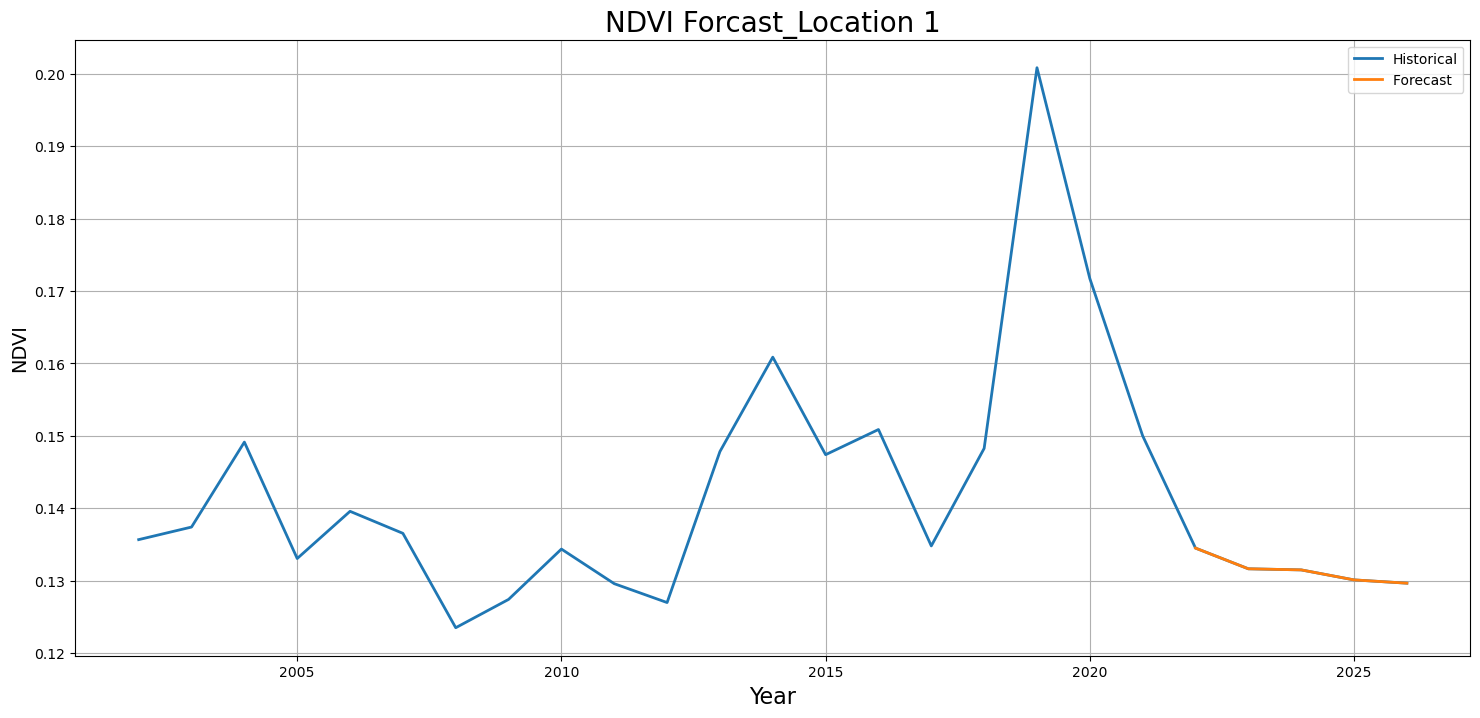

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(L1_NDVI['year'], L1_NDVI['NDVI'],lw=2, label='Historical')
ax.plot(df['year'], df['NDVI'],lw=2, label="Forecast ")
ax.set_xlabel('Year',fontsize=16)
ax.set_ylabel('NDVI',fontsize=14)
ax.set_title("NDVI Forcast_Location 1",fontsize=20)
ax.grid()
ax.legend();

In [19]:

L2_arr=L2_2022_2026.reshape(-1,1)
L2_arr_new=np.concatenate((year_arr, L2_arr),axis=1)
df2 = pd.DataFrame(L2_arr_new, columns = ['year','NDVI'])
L2_NDVI=year_mean.loc[year_mean['loc'] == 'L2']
L2_NDVI=pd.concat([L2_NDVI, df2], ignore_index=True)
L2_NDVI.loc[:,'year']=L2_NDVI.loc[:,'year'].astype(int)
L2_NDVI

C:\Users\smufl\AppData\Local\Temp\ipykernel_1864\710334330.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  L2_NDVI.loc[:,'year']=L2_NDVI.loc[:,'year'].astype(int)


,year,loc,NDVI,location
0,2002,L2,0.135652,2.0
1,2003,L2,0.137391,2.0
2,2004,L2,0.149130,2.0
3,2005,L2,0.133043,2.0
4,2006,L2,0.139565,2.0
5,2007,L2,0.136522,2.0
6,2008,L2,0.123478,2.0
7,2009,L2,0.127391,2.0
8,2010,L2,0.134348,2.0
9,2011,L2,0.129565,2.0


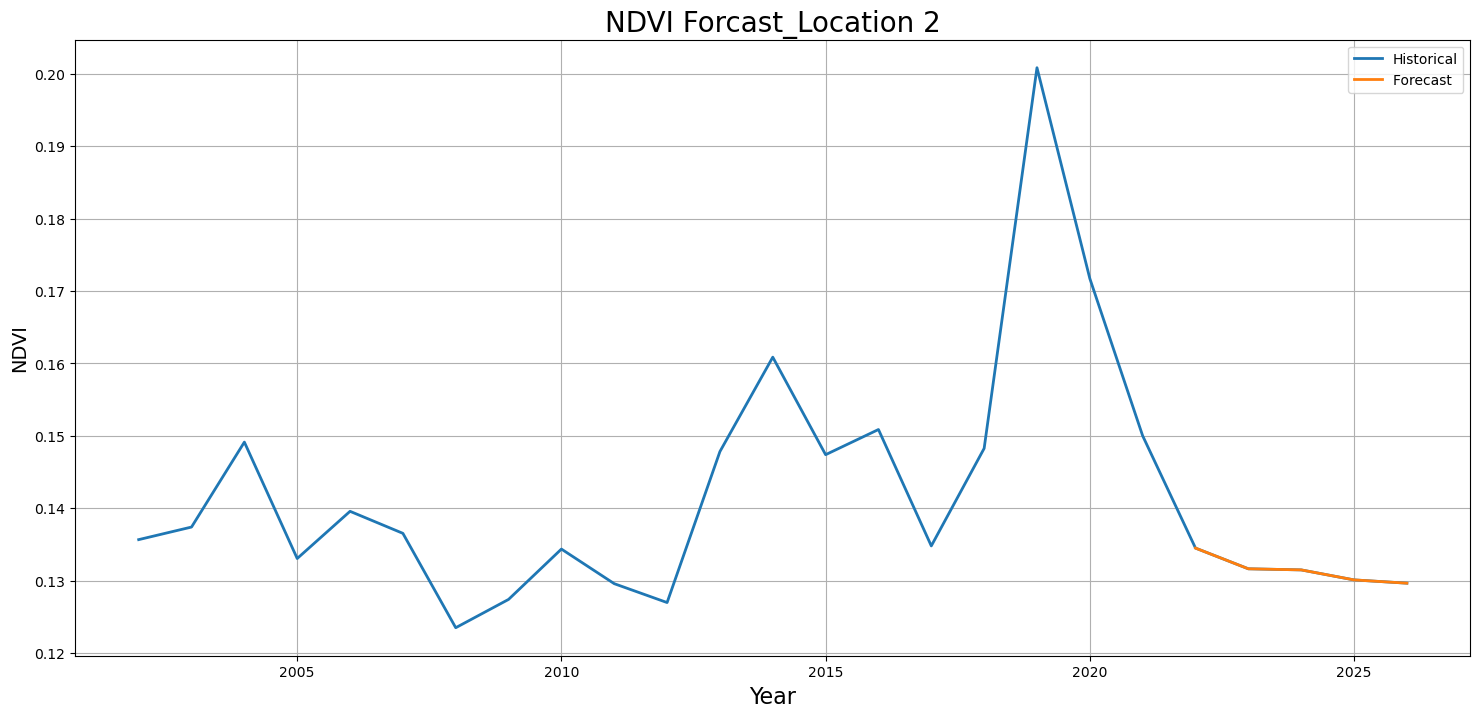

In [20]:
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(L2_NDVI['year'], L2_NDVI['NDVI'],lw=2, label='Historical')
ax.plot(df2['year'], df2['NDVI'],lw=2, label="Forecast ")
ax.set_xlabel('Year',fontsize=16)
ax.set_ylabel('NDVI',fontsize=14)
ax.set_title("NDVI Forcast_Location 2",fontsize=20)
ax.grid()
ax.legend();